In [15]:
import numpy as np
import pandas as pd
import scanpy as sc

adata = sc.datasets.pbmc3k()
adata.var_names_make_unique()

adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

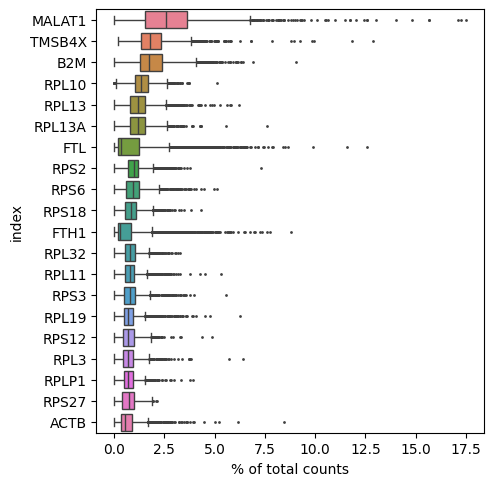

In [16]:
# 质量控制
# 查询高表达的前20个基因
sc.pl.highest_expr_genes(adata, n_top=20, save='_pbmc3k.png')

In [17]:
# 基本过滤
# 此处的标准：
    # 一个正常细胞中基因至少有200个
    # 一个正常基因需要在至少3个细胞中出现
sc.pp.filter_cells(adata, min_genes=200) 
sc.pp.filter_genes(adata, min_cells=3) 

In [18]:
# 计算质量控制指标
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

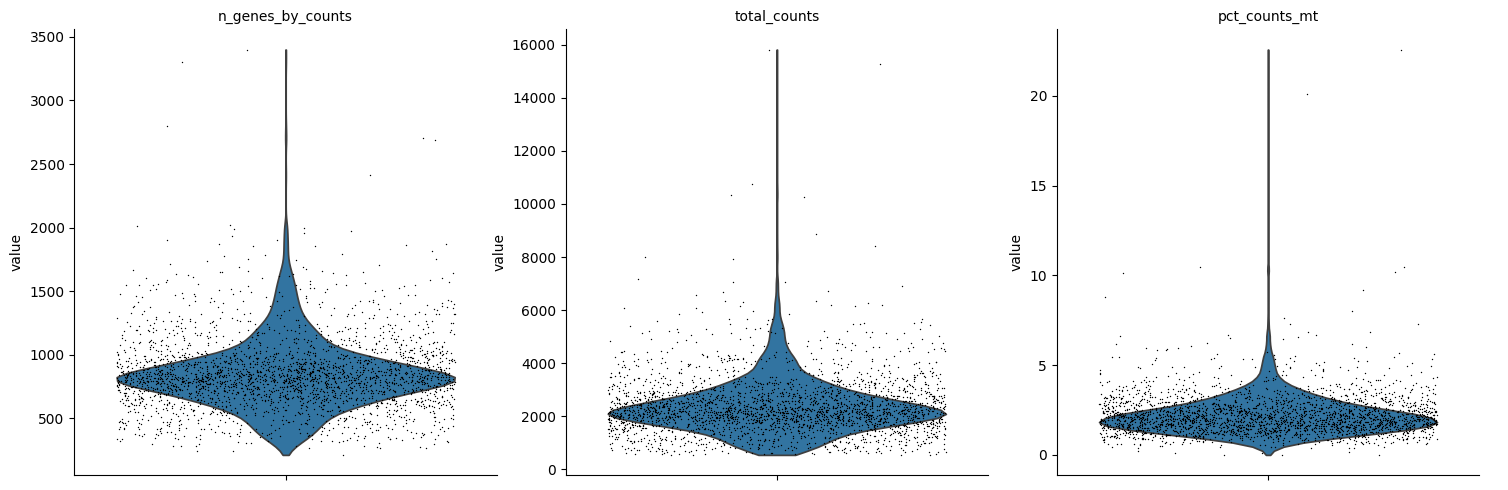

In [19]:
# 计算质量度量的小提琴图
    # 计量矩阵中基因表达的数量
    # 每个细胞的total_counts
    # 线粒体基因技术的百分比
#  小提琴图是一种展示数据分布情况的图表，它结合了箱形图和密度图的特点，可以显示数据的分布形状以及概率密度。
    
sc.pl.violin(
    adata, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], # 列出要绘制violin的数据字段
    jitter=0.4,  # 随机抖动程度
    multi_panel=True, 
    save='_pbmc3k.png'
)

/home/shenc/anaconda3/envs/rna1/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  order=order,


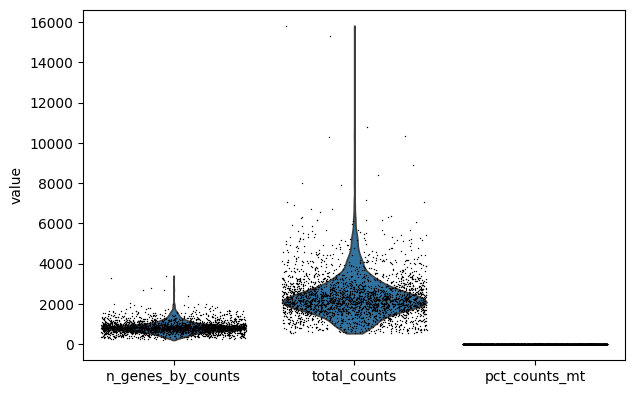

In [20]:
sc.pl.violin(
    adata, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], # 列出要绘制violin的数据字段
    jitter=0.4,  # 随机抖动程度
    multi_panel=False, 
    save='_pbmc3k_1.png'
)
# 这个图像不是一个好例子，因为不同指标的数据规模差别较大，最好还是使用multi_panel=True吧

In [21]:
# 根据基因数量和线粒体百分比进行过滤

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [22]:
# 数据标准化
    # 总计数归一化
    # 对数化
    
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/shenc/anaconda3/envs/rna1/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  warn(


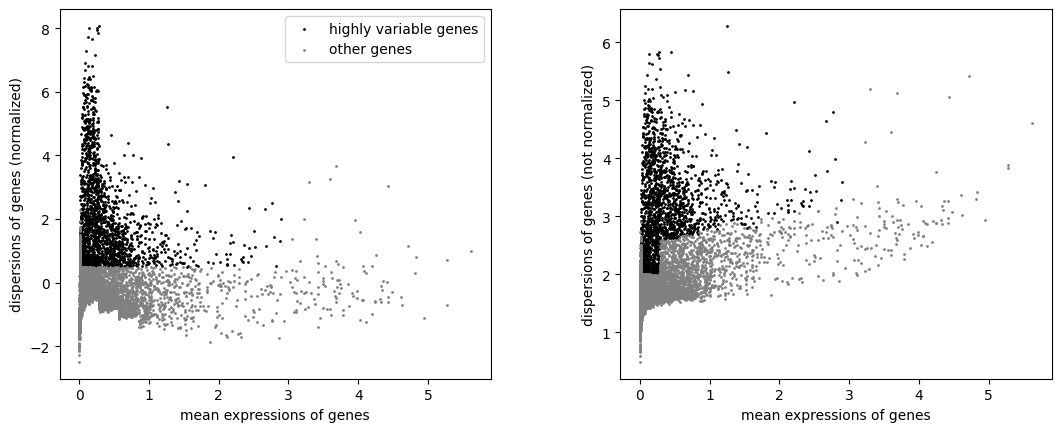

In [23]:
# 特征提取

# 识别高可变基因并进行过滤
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata, save='_pbmc3k.png')

In [24]:
# 保留原始数据，之后进行过滤
# 注意这里只能执行一次哈
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

adata.raw.shape, adata.shape

((2638, 13714), (2638, 1838))

In [26]:
# 进一步做数据标准化

# 将数据缩放到单位方差
sc.pp.regress_out(
    adata, 
    ['total_counts', 'pct_counts_mt']# 要回归出去的变量列表
)
sc.pp.scale(adata, max_value=10)

In [27]:
# 保存数据
results_file = './data/pbmc3k_processed.h5ad'
adata.write(results_file)

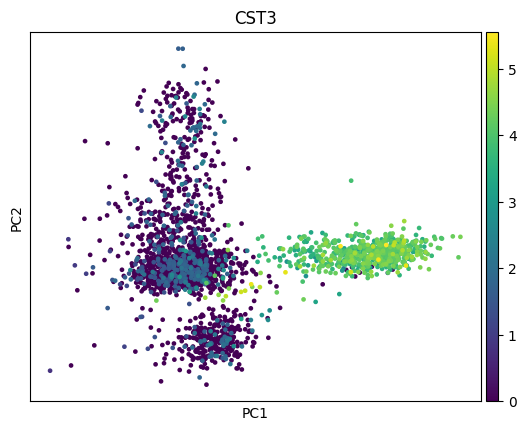

In [28]:
# 降维和可视化

# 使用PCA进行降维
sc.tl.pca(
    adata, 
    svd_solver='arpack' # SVD求解器，'arpack' 适用于大型稀疏矩阵
)
sc.pl.pca(adata, color='CST3', save='_pbmc3k_CST3.png')

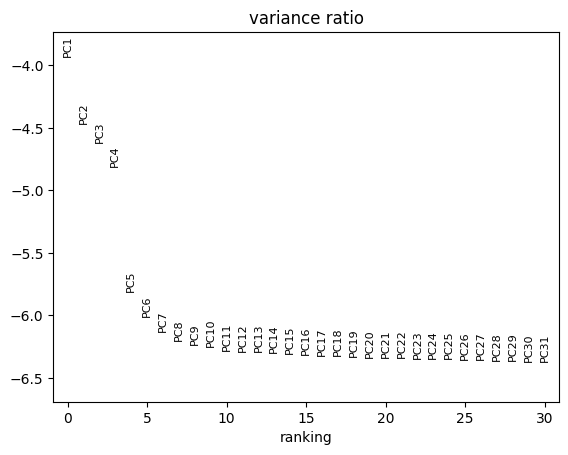

In [30]:
# 检查单个PC对数据方差的影响

sc.pl.pca_variance_ratio(adata, log=True, save='_pbmc3k_pc.png')

In [31]:
# 计算neighbor，用于后面的UMAP降维

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/home/shenc/anaconda3/envs/rna1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


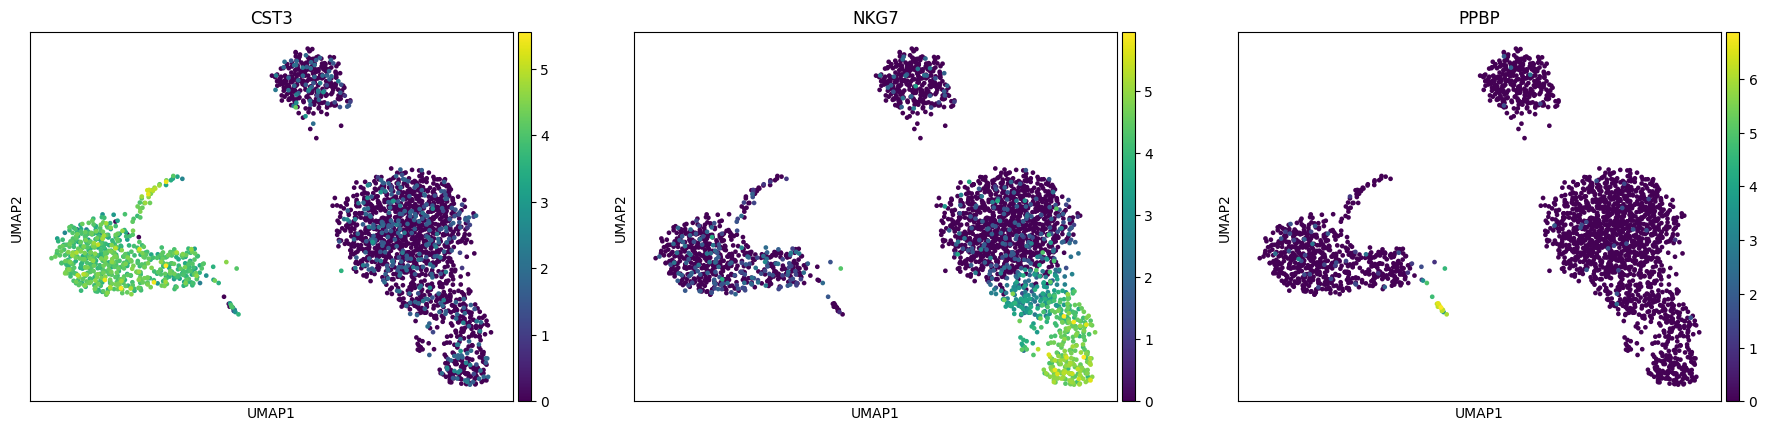

In [32]:
# UMAP降维

sc.tl.umap(adata)
sc.pl.umap(
    adata, 
    color=['CST3', 'NKG7', 'PPBP'],  # 颜色分别参考这三部分
    save='_pbmc3k_CST3_NKG7_PPBP.png'
)

/home/shenc/anaconda3/envs/rna1/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


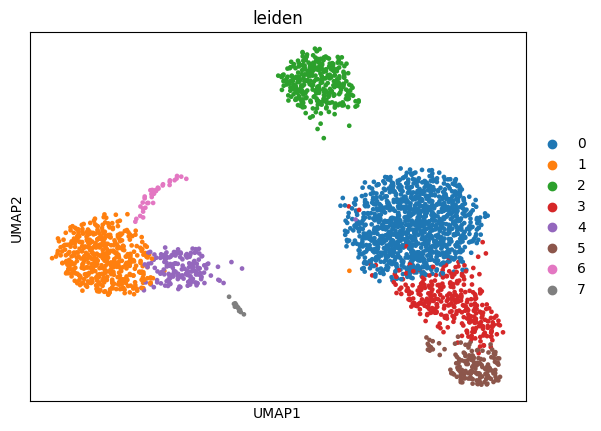

In [33]:
# leiden聚类

sc.tl.leiden(adata)
sc.pl.umap(
    adata, 
    color=['leiden'], 
    save='_pbmc3k_leiden.png'
)